In [1]:
import json
import requests
import tensorflow as tf
from PIL import Image
import numpy as np
import zipfile
import matplotlib.pyplot as plt

In [2]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
test_data_num = 100
BASE_PATH = "run/"
with open(BASE_PATH+"data.json", "r") as f:
    data = json.load(f)

In [3]:
images = []
rotations = []
positions = []

for item in data["Data"]:
    image = Image.open(BASE_PATH + item["image"])
    #image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    image = np.array(image) / 127.5 - 1
    rot = [[0 for x in range(3)] for y in range(1)] 
    rot[0][0] = item["orientation"][0]
    rot[0][1] = item["orientation"][1]
    rot[0][2] = item["orientation"][2]
    position = item["position"]
    images.append(image[None,:,:,:3])
    rotations.append(rot)
    positions.append(position)


In [4]:
images = np.array(images)
rotations = np.array(rotations)
positions = np.array(positions)

In [5]:
train_images = images[test_data_num:]
train_rotations = rotations[test_data_num:]
train_positions = positions[test_data_num:]

test_images = images[:test_data_num]
test_rotations = rotations[:test_data_num]
test_positions = positions[:test_data_num]

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_rotations))
validation_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_rotations))

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print(len(list(train_dataset)))
print(len(list(test_dataset)))
print(len(list(validation_dataset)))

900
20
80


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
# Neurális hálózat létrehozása
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3)  # 3 neuron a három lebegőpontos értékhez, nincs aktivációs függvény (lineáris réteg)
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [10]:
# Neurális hálózat tanítása
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [11]:
model.evaluate(test_dataset)

20/20 [==============================] - 0s 8ms/step - loss: 0.3427 - accuracy: 0.4500


[0.3427313268184662, 0.44999998807907104]

In [12]:
model.fit(train_dataset, epochs=30, validation_data=validation_dataset)

Epoch 1/30
900/900 [==============================] - 74s 82ms/step - loss: 0.3306 - accuracy: 0.6878 - val_loss: 0.1000 - val_accuracy: 0.8250
Epoch 2/30
900/900 [==============================] - 75s 83ms/step - loss: 0.0867 - accuracy: 0.8333 - val_loss: 0.1060 - val_accuracy: 0.8000
Epoch 3/30
900/900 [==============================] - 75s 84ms/step - loss: 0.0634 - accuracy: 0.8844 - val_loss: 0.0968 - val_accuracy: 0.8250
Epoch 4/30
900/900 [==============================] - 76s 84ms/step - loss: 0.0402 - accuracy: 0.9000 - val_loss: 0.1212 - val_accuracy: 0.7750
Epoch 5/30
900/900 [==============================] - 75s 84ms/step - loss: 0.0339 - accuracy: 0.9178 - val_loss: 0.1075 - val_accuracy: 0.8500
Epoch 6/30
900/900 [==============================] - 76s 84ms/step - loss: 0.0244 - accuracy: 0.9389 - val_loss: 0.0923 - val_accuracy: 0.8500
Epoch 7/30
900/900 [==============================] - 75s 84ms/step - loss: 0.0211 - accuracy: 0.9333 - val_loss: 0.0938 - val_accuracy:

In [13]:
model.evaluate(test_dataset)

 1/20 [>.............................] - ETA: 0s - loss: 0.2491 - accuracy: 0.0000e+00

20/20 [==============================] - 0s 8ms/step - loss: 0.0765 - accuracy: 0.8500


[0.07650276273488998, 0.8500000238418579]

In [14]:
def plot(guess, t_pos, t_rot, t_image):
    center_x = IMAGE_WIDTH/2
    center_y = IMAGE_HEIGHT/2

    mag = np.sqrt(t_pos.dot(t_pos))
    multi = 1

    pos_x = t_pos[0] * center_x * multi / mag + center_x
    pos_y = t_pos[1] * center_y * multi / mag + center_y

    screen_rot_x = t_rot[0] * center_x * multi / mag + pos_x
    screen_rot_y = t_rot[1] * center_y * multi / mag + pos_y

    screen_guess_rot_x = guess[0] * center_x * multi / mag + pos_x
    screen_guess_rot_y = guess[1] * center_y * multi / mag + pos_y


    x1 = [screen_rot_x, pos_x]; y1 = [screen_rot_y, pos_y] 
    x2 = [screen_guess_rot_x, pos_x]; y2 = [screen_guess_rot_y, pos_y] 


    fig, ax = plt.subplots()
    ax.axline((x1[0], y1[0]), (x1[1], y1[1]), color='green', label='by points')
    ax.axline((x2[0], y2[0]), (x2[1], y2[1]), color='red', label='by points')

    #plt.plot(x, y, color="purple", linewidth=3) 
    plt.ylim([0, t_image.shape[0]])
    plt.imshow(np.flipud(t_image))

    print("Rot pred:   ", pred[0])
    print("Rotation:   ", t_rot)
    print("Position: ", t_pos)
    plt.show() 

In [15]:
test_index = 0

1/1 [==============================] - 0s 14ms/step
Rot pred:    [-0.6471924  -0.05638383 -0.7697502 ]
Rotation:    [-0.45245457 -0.07028815 -0.88901329]
Position:  [ 0.56122398 -0.95742035 12.21376705]


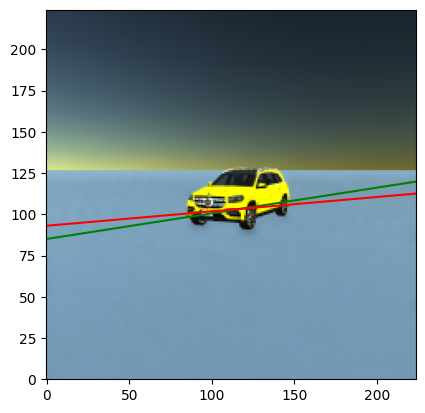

In [51]:
test = []
test.append(test_images[test_index])
test = np.array(test)
test_image = tf.data.Dataset.from_tensor_slices((test, test_rotations[test_index]))

pred = model.predict(test_image)

modified = []
for image in test:
    image = np.array(image) + 1
    image = np.array(image) / 2
    modified.append(image)
modified = np.array(modified)


plot(pred[0], test_positions[test_index], test_rotations[test_index][0], modified[0][0])
test_index = test_index +1